In [40]:
pip install pandas numpy matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
import warnings

In [107]:
warnings.filterwarnings("ignore", category=UserWarning)

In [117]:
csv_path = r"C:\singh\temp\singh\Nat_Gas.csv"
df_raw = pd.read_csv(csv_path)

In [119]:
print("COLUMNS:")
print(df_raw.columns.tolist())
print("\nHEAD (first 8 rows):")
display(df_raw.head(8))

COLUMNS:
['Dates', 'Prices']

HEAD (first 8 rows):


,Dates,Prices
0,10/31/20,10.10
1,11/30/20,10.30
2,12/31/20,11.00
3,1/31/21,10.90
4,2/28/21,10.90
5,3/31/21,10.90
6,4/30/21,10.40
7,5/31/21,9.84


In [110]:
candidates = []
for c in df_raw.columns:
    # try parse first 20 non-nulls
    sample = df_raw[c].dropna().astype(str).head(20).tolist()
    parsed = 0
    for s in sample:
        try:
            pd.to_datetime(s, errors='raise')
            parsed += 1
        except Exception:
            pass
    pct = parsed / max(1, len(sample))
    candidates.append((c, pct, df_raw[c].dropna().astype(str).head(5).tolist()))

print("Date-likeness score (col, fraction of first-20 values parseable as dates, sample values):")
for t in candidates:
    print(t)


Date-likeness score (col, fraction of first-20 values parseable as dates, sample values):
('Dates', 1.0, ['10/31/20', '11/30/20', '12/31/20', '1/31/21', '2/28/21'])
('Prices', 0.0, ['10.1', '10.3', '11.0', '10.9', '10.9'])


In [120]:
num_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns (likely price candidates):", num_cols)

# also show columns that contain currency-like strings
str_cols = []
for c in df_raw.columns:
    if df_raw[c].dropna().astype(str).str.contains(r'[\$\£\€|,]').any():
        str_cols.append(c)
print("Columns with currency characters (possible price columns):", str_cols)


Numeric columns (likely price candidates): ['Prices']
Columns with currency characters (possible price columns): []


In [121]:
date_col = 'Dates' 
price_col = 'Prices' 

print("Using date_col =", date_col, "and price_col =", price_col)

temp = df_raw[[date_col, price_col]].copy()
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
temp[price_col] = pd.to_numeric(temp[price_col].astype(str).str.replace(r'[^\d\.\-]', '', regex=True), errors='coerce')
print("\nParsed sample:")
display(temp.head(8))

Using date_col = Dates and price_col = Prices

Parsed sample:


,Dates,Prices
0,10/31/20,10.10
1,11/30/20,10.30
2,12/31/20,11.00
3,1/31/21,10.90
4,2/28/21,10.90
5,3/31/21,10.90
6,4/30/21,10.40
7,5/31/21,9.84


In [111]:
def prepare_features_from_columns(df_raw, date_col, price_col):
    df = df_raw[[date_col, price_col]].copy()
    df.columns = ["Date", "Price"]
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)
    df["Price"] = pd.to_numeric(df["Price"].astype(str).str.replace(r'[^\d\.\-]', '', regex=True), errors="coerce")
    df = df.dropna(subset=["Price"]).reset_index(drop=True)
    df["ordinal"] = df["Date"].map(pd.Timestamp.toordinal).astype(int)
    df["month"] = df["Date"].dt.month
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df

df = prepare_features_from_columns(df_raw, date_col, price_col)
print("Prepared rows:", len(df))
print("Date range:", df["Date"].min().date(), "to", df["Date"].max().date())
display(df.head())

Prepared rows: 48
Date range: 2020-10-31 to 2024-09-30


,Date,Price,ordinal,month,month_sin,month_cos
0,2020-10-31,10.1,737729,10,-8.660254e-01,0.500000
1,2020-11-30,10.3,737759,11,-5.000000e-01,0.866025
2,2020-12-31,11.0,737790,12,-2.449294e-16,1.000000
3,2021-01-31,10.9,737821,1,5.000000e-01,0.866025
4,2021-02-28,10.9,737849,2,8.660254e-01,0.500000


In [112]:
# Split by time
split_idx = int(len(df) * 0.8)
X_train = df[["ordinal", "month_sin", "month_cos"]].iloc[:split_idx]
y_train = df["Price"].iloc[:split_idx]
X_val = df[["ordinal", "month_sin", "month_cos"]].iloc[split_idx:]
y_val = df["Price"].iloc[split_idx:]

# Train Gradient Boosting model
model = GradientBoostingRegressor(
    n_estimators=1000, learning_rate=0.03, max_depth=3, random_state=42
)
model.fit(X_train, y_train)

# Validation performance
y_pred_val = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val)
print(f"Validation MAE: {mae:.3f}, RMSE: {rmse:.3f}")


Validation MAE: 0.338, RMSE: 0.156


In [113]:
# Generate next 1 year of daily dates
last_date = df["Date"].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365, freq="D")

# Prepare features for those future dates
def make_feature_row(dates):
    s = pd.Series(pd.to_datetime(dates))
    df_f = pd.DataFrame({"Date": s})
    df_f["ordinal"] = df_f["Date"].map(pd.Timestamp.toordinal).astype(int)
    df_f["month"] = df_f["Date"].dt.month
    df_f["month_sin"] = np.sin(2 * np.pi * df_f["month"] / 12)
    df_f["month_cos"] = np.cos(2 * np.pi * df_f["month"] / 12)
    return df_f[["ordinal", "month_sin", "month_cos"]]

X_future = make_feature_row(future_dates)
y_future_pred = model.predict(X_future)


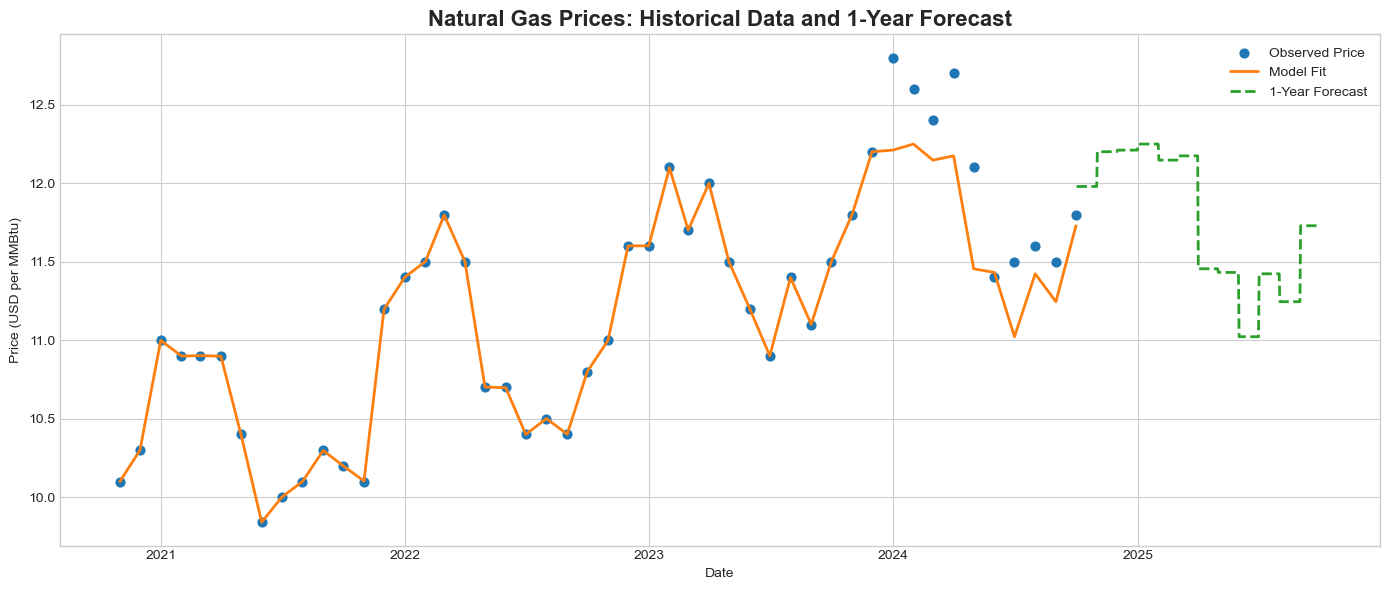

In [114]:
# Predicted (fitted) values for historical data
df["Predicted"] = model.predict(df[["ordinal", "month_sin", "month_cos"]])

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(14,6))

# Actual prices
ax.scatter(df["Date"], df["Price"], color="#1f77b4", label="Observed Price", s=40)

# Fitted line
ax.plot(df["Date"], df["Predicted"], color="#ff7f0e", linewidth=2, label="Model Fit")

# Future forecast
ax.plot(future_dates, y_future_pred, color="#2ca02c", linestyle="--", linewidth=2, label="1-Year Forecast")

ax.set_title("Natural Gas Prices: Historical Data and 1-Year Forecast", fontsize=16, weight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD per MMBtu)")
ax.legend()
plt.tight_layout()
plt.show()


In [115]:
residuals = y_val - y_pred_val
resid_std = residuals.std(ddof=1)

def estimate_price_for_date(date_string):
    date = pd.to_datetime(date_string, errors="coerce")
    if pd.isna(date):
        raise ValueError("Invalid date format. Use 'YYYY-MM-DD'.")
    X_in = make_feature_row([date])
    pred = model.predict(X_in)[0]
    lower = pred - 1.96 * resid_std
    upper = pred + 1.96 * resid_std
    print(f"Estimated price on {date.date()}: {pred:.3f} USD/MMBtu (95% CI: {lower:.3f} - {upper:.3f})")
    return {"date": date.date(), "estimate": pred, "lower_95": lower, "upper_95": upper}


In [116]:
estimate_price_for_date("2023-07-31")  # past date
estimate_price_for_date("2025-08-01")  # 1 year into the future


Estimated price on 2023-07-31: 11.399 USD/MMBtu (95% CI: 10.956 - 11.842)
Estimated price on 2025-08-01: 11.245 USD/MMBtu (95% CI: 10.802 - 11.688)


{'date': datetime.date(2025, 8, 1),
 'estimate': np.float64(11.24523770148279),
 'lower_95': np.float64(10.802046672632812),
 'upper_95': np.float64(11.688428730332767)}